In [1]:
"""
references:
https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376
https://pytorch.org/vision/stable/models.html
https://pytorch.org/vision/stable/models/generated/torchvision.models.squeezenet1_1.html#torchvision.models.SqueezeNet1_1_Weights
https://www-sciencedirect-com.ezproxy.neu.edu/science/article/pii/S0957417420305200
https://www-sciencedirect-com.ezproxy.neu.edu/science/article/pii/S0893608022004920
https://medium.com/@murcielagolambo/making-the-right-choice-pre-trained-models-vs-custom-models-34e7c8e06786
"""

'\nreferences:\nhttps://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification\n'

In [2]:
pip install fastbook

In [3]:
# Import the required modules
import os
import gdown
import zipfile
from zipfile import ZipFile
from fastai.vision.all import *
from fastbook import *
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, transforms
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

In [4]:
# Check whether or not the "cuda" service is available
print(torch.cuda.is_available())

True


In [5]:
# Set seeds to ensure the outputs are reproducible
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)

In [6]:
# Redirect to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
"""
Load the dataset
"""
dataset_owner = "samuelcortinhas"
dataset_name = "cats-and-dogs-image-classification"

# Use the Kaggle API to download the dataset
os.system(f'kaggle datasets download -d {dataset_owner}/{dataset_name}')

# Unzip the downloaded file
with ZipFile(f'{dataset_name}.zip', 'r') as zip_ref:
    zip_ref.extractall('cats_and_dogs')

In [8]:
# Set the original weights
weights = SqueezeNet1_1_Weights.DEFAULT

# Create an instance for the model "squeezenet1_1"
model_1 = squeezenet1_1(weights=weights)

In [10]:
# Observe the model
print(model_1)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

**From the output below, we can conclude that the outputs for this model are 1000, indicating the need for change**

In [9]:
# Modify the model accordingly
# Change the outputs from 1000 to 2
model_1.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

In [11]:
# Store the images into data loaders
path = '/content/drive/My Drive/cats_and_dogs/'

dls = ImageDataLoaders.from_folder(
    path,
    train="train",
    valid="test",
    batch_size=64,
    shuffle=True,
    item_tfms=Resize(224),
    normalize=True,
    seed=42
)

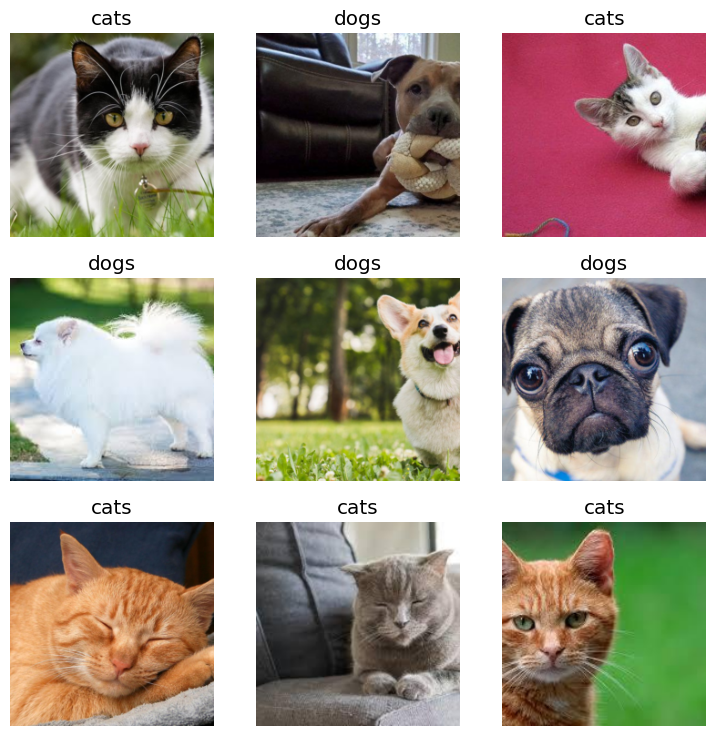

In [12]:
# Review the images
dls.show_batch()

In [13]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [14]:
# Create an instance of Learner
learn = Learner(dls, model_1, opt_func=SGD, loss_func=criterion)

In [15]:
# Get access to the GPU service
if torch.cuda.is_available() == True:
  learn.model = learn.model.to('cuda')
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [16]:
# Fit the model
learn.fit(40, 0.001)

epoch,train_loss,valid_loss,time
0,0.724495,0.668290,00:19
1,0.670011,0.612170,00:12
2,0.635066,0.556995,00:10
3,0.597439,0.504982,00:11
4,0.567668,0.460157,00:12
5,0.537545,0.424192,00:11
6,0.508685,0.389598,00:10
7,0.482358,0.361070,00:12
8,0.456349,0.342180,00:13
9,0.435663,0.325041,00:12


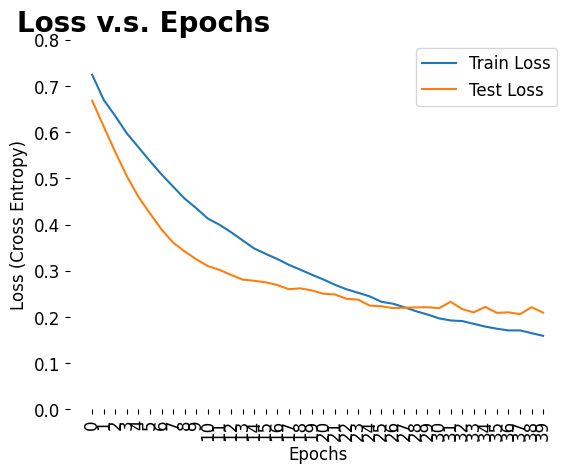

In [17]:
# Visuzlise the loss on the training and testing datasets
for i in range(2):
  plt.plot(L(learn.recorder.values).itemgot(i))
  plt.xticks(range(len(learn.recorder.values)))

  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (Cross Entropy)')
  plt.title('Loss v.s. Epochs', fontsize=20, weight='bold', x=0.15)
  plt.xticks(rotation=90, ha='center')
  plt.yticks(np.arange(0, max(L(learn.recorder.values).itemgot(0)) + 0.1, 0.1))
  ax = plt.gca()
  ax.set_frame_on(False)


In [19]:
# Obtain the predicted values and labels
preds, targs = learn.get_preds()

In [21]:
# Create a list to compare the predicted values for each sample
prediction_list = []
for i, j in preds:
  if i>j:
    prediction_cats_and_dogs = 0
  else:
    prediction_cats_and_dogs = 1
  prediction_list.append(prediction_cats_and_dogs)

In [23]:
# Convert the labels into a list
targs_list = targs.tolist()

In [24]:
# Build a confusion matrix
cm = confusion_matrix(targs_list, prediction_list)
cm

array([[65,  5],
       [ 6, 64]])

In [25]:
# Convert the confusion matrix into a data frame
cm_df = pd.DataFrame(cm, np.unique(targs_list), np.unique(targs_list))
cm_df

,0,1
0,65,5
1,6,64
